<h3><b>Train a Neural Machine Translation model using attention mechanism to enhance it's performance.</b></h3>

<h3><i>Step no.0: setup</i></h3>

In [3]:
# Import libs
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nmt.dataset import Hyperparameters
from nmt.dataset import get_anki_dataset
from nmt.model import Translator
from nmt.model import masked_loss, masked_acc

In [4]:
# define a hyper-parametrs object to hold required hyperparamters in on place.
hp = Hyperparameters(
    batch_size=32,
    units=512,
    num_heads=1,
    vocab_size=15000,
)

for p, v in vars(hp).items():
    print(f"{p:15} : {v}")

batch_size      : 32
units           : 512
num_heads       : 1
vocab_size      : 15000


<h4><i>Step no.1: Load and explore dataset.</i></h4>

In [5]:
# define a function to filter out good-quality sentences from additional dataset

def filter_or_clean(per, eng):
    """Based on persian sentences inside the additional dataset, it seems that 
    there exist some sentences which contains alot of ، and indeed most of 
    them are not grammatically correct due to preprocessing function inside 
    nmt_dataset_augmentation.ipynb which is the source of these additional 
    sentences. Most of the sentences with this characteristic are not suitable for
    training the model, so we remove them to increase the qualtity of the extended
    dataset."""
    
    # Filtering
    if per.count("،") > 4:
        return None, eng
    
    # Cleaning
    per = per.replace("من", "").replace("دوم", "").replace("ii", "").replace("I", "").replace("II", "")
    eng = eng.replace("I", "").replace("II", "").replace("ii", "")
    return per, eng

In [6]:
# load dataset
print("loading dataset and tokenizers ...", end=" ")
dataset, (inputs_tokenizer, targets_tokenizer) = get_anki_dataset(
    vocab_size=hp.vocab_size, 
    batch_size=hp.batch_size,
    extend=True,
    extend_post_processor=filter_or_clean,
)

print("done .")

loading dataset and tokenizers ... done .


In [7]:
# a quick glance at dataset shape
for inputs, outputs in dataset.take(1):
    enc_input, dec_input = inputs['enc_inputs'], inputs["dec_inputs"]
    print(f"encoder input shape:{'':3} {enc_input.shape}")
    print(f"decoder input shape:{'':3} {dec_input.shape}")
    print(f"output/target shape:{'':3} {outputs.shape}")

encoder input shape:    (32, 42)
decoder input shape:    (32, 36)
output/target shape:    (32, 36)


In [8]:
# save the tokenizers config to disk, so we can build a same tokenizer as these later.
tokenizers_path = os.path.join(".", "tokenizers")
if not os.path.exists(tokenizers_path):
    os.mkdir(tokenizers_path)

# save tokenizers config
inputs_tokenizer_filepath = os.path.join(tokenizers_path, "inputs_tokenizer_config.pkl")
targets_tokenizer_filepath = os.path.join(tokenizers_path, "targets_tokenizer_config.pkl")
pickle.dump({'config': inputs_tokenizer.get_config(), 'weights': inputs_tokenizer.get_weights()}, 
            open(inputs_tokenizer_filepath, "wb"))
pickle.dump({'config': targets_tokenizer.get_config(), 'weights': targets_tokenizer.get_weights()}, 
            open(targets_tokenizer_filepath, "wb"))
# =================================================== #


# it's better to save the vocabularies too.
input_vocabs_filepath = os.path.join(tokenizers_path, "inputs_vocab.npy")
target_vocabs_filepath = os.path.join(tokenizers_path, "targets_vocab.npy")

inputs_vocab = np.array(inputs_tokenizer.get_vocabulary())
targets_vocab = np.array(targets_tokenizer.get_vocabulary())

with open(input_vocabs_filepath, 'wb') as file:
    np.save(file, inputs_vocab)
with open(target_vocabs_filepath, 'wb') as file:
    np.save(file, targets_vocab)
    # =================================================== #

In [9]:
## HOW TO LOAD 
## 1. tokenizers

#from_disk = pickle.load(open(inputs_tokenizer_filepath, "rb"))
#inputs_tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
#inputs_tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))   # call with sume dummy data
#inputs_tokenizer.set_weights(from_disk['weights'])

#from_disk = pickle.load(open(targets_tokenizer_filepath, "rb"))
#targets_tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
#targets_tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))   # call with sume dummy data
#targets_tokenizer.set_weights(from_disk['weights'])

## 2. load vocabs
#with open(input_vocabs_filepath, 'rb') as file:
#    inputs_vocab = np.load(file)

#with open(targets_tokenizer_filepath, 'rb') as file:
#    targets_vocab = np.load(file)

## the first part is sufficent for loading tokenizers.

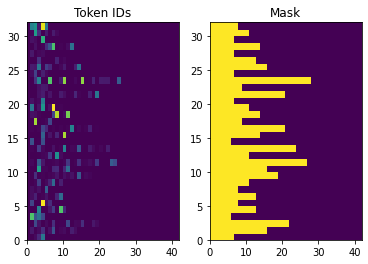

In [10]:
plt.subplot(1, 2, 1)
plt.pcolormesh(enc_input)
_ = plt.title("Token IDs")

plt.subplot(1, 2, 2)
plt.pcolormesh(enc_input != 0)
_ = plt.title("Mask")

In [11]:
# Define a function to convert a tokenized sentence into text

source_vocabs = np.array(inputs_tokenizer.get_vocabulary())
target_vocabs = np.array(targets_tokenizer.get_vocabulary())

def convert_tokens_to_text(tokens, lang="persian"):
    tokens = tokens.numpy() if isinstance(tokens, tf.RaggedTensor) else tokens
    if lang == "persian":
        return ' '.join(source_vocabs[tokens][0])
    return ' '.join(target_vocabs[tokens][0])

<h3><i>Step no.2: Build the Model.</i></h3>

In [12]:
# Build the Model

nmt_model = Translator(
    inputs_tokenizer,
    targets_tokenizer,
    units=hp.units,
    attn_num_heads=hp.num_heads,
)

In [13]:
# Compile the Model
nmt_model.compile(optimizer="adam", loss=masked_loss, 
                  metrics=[masked_loss, masked_acc])

In [14]:
history = nmt_model.fit(
    dataset.repeat(),
    epochs=100,
    steps_per_epoch = 100,
)

Epoch 1/100
100/100 [==============================] - 41s 221ms/step - loss: 6.4548 - masked_loss: 6.4548 - masked_acc: 0.1225
Epoch 2/100
100/100 [==============================] - 10s 103ms/step - loss: 5.6176 - masked_loss: 5.6176 - masked_acc: 0.2139
Epoch 3/100
100/100 [==============================] - 9s 91ms/step - loss: 4.8287 - masked_loss: 4.8262 - masked_acc: 0.2842
Epoch 4/100
100/100 [==============================] - 7s 69ms/step - loss: 4.3537 - masked_loss: 4.3537 - masked_acc: 0.3344
Epoch 5/100
100/100 [==============================] - 7s 73ms/step - loss: 4.0170 - masked_loss: 4.0163 - masked_acc: 0.3694
Epoch 6/100
100/100 [==============================] - 7s 71ms/step - loss: 2.9824 - masked_loss: 2.9824 - masked_acc: 0.4609
Epoch 7/100
100/100 [==============================] - 6s 64ms/step - loss: 2.9541 - masked_loss: 2.9541 - masked_acc: 0.4721
Epoch 8/100
100/100 [==============================] - 7s 65ms/step - loss: 2.2075 - masked_loss: 2.2136 - masked_

<h3><i>Step no.3: Plot the loss and accuracy history.</i></h3>

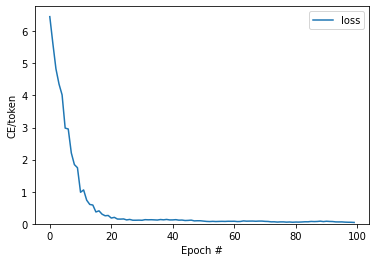

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

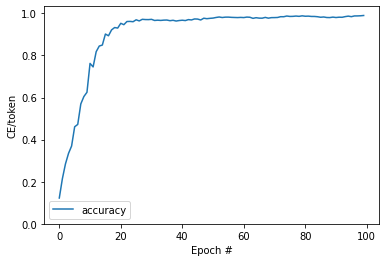

In [16]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

<h3><i>Step no.4: Evaluate the model</i></h3>

In [17]:
texts = ["سلام . حالت چطوره", "با تو موافقم", "من داشتم قدم می زدم", "دوست من یک دکتر است"]

for t in texts:
    result = nmt_model.translate([t])
    translated = result[0].numpy().decode()
    print(f"{t:10}: {translated}")
    print()

سلام . حالت چطوره: for it is not lawful . 

با تو موافقم: confused with you , 

من داشتم قدم می زدم: i was taking a 

دوست من یک دکتر است: its a friend to lazica , 



In [ ]:
# it needs to be trained on more data for more epochs.